2025-02-01 12:34:52,119 - INFO - Dataset from 'drug_dataset1.csv' loaded successfully!
2025-02-01 12:34:52,119 - INFO - Dataset Preview:

2025-02-01 12:34:52,119 - INFO -    Age Sex      BP Cholesterol   Drug
0   58   M     LOW      NORMAL  DrugB
1   48   F  NORMAL      NORMAL  DrugA
2   34   M    HIGH      NORMAL  DrugB
3   62   F  NORMAL        HIGH  DrugA
4   27   F     LOW        HIGH  DrugB
2025-02-01 12:34:52,131 - INFO - Dataset from 'drug_dataset2.csv' loaded successfully!
2025-02-01 12:34:52,131 - INFO - Dataset Preview:

2025-02-01 12:34:52,131 - INFO -    Age Sex      BP Cholesterol   Drug
0   58   M     LOW      NORMAL  DrugB
1   48   F  NORMAL      NORMAL  DrugA
2   34   M    HIGH      NORMAL  DrugB
3   62   F  NORMAL        HIGH  DrugA
4   27   F     LOW        HIGH  DrugB
2025-02-01 12:34:52,139 - INFO - Dataset from 'drug_dataset3.csv' loaded successfully!
2025-02-01 12:34:52,139 - INFO - Dataset Preview:

2025-02-01 12:34:52,139 - INFO -    Age Sex      BP Cholesterol 

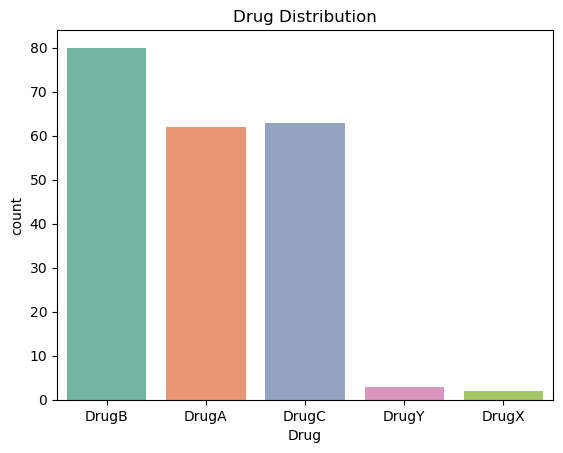

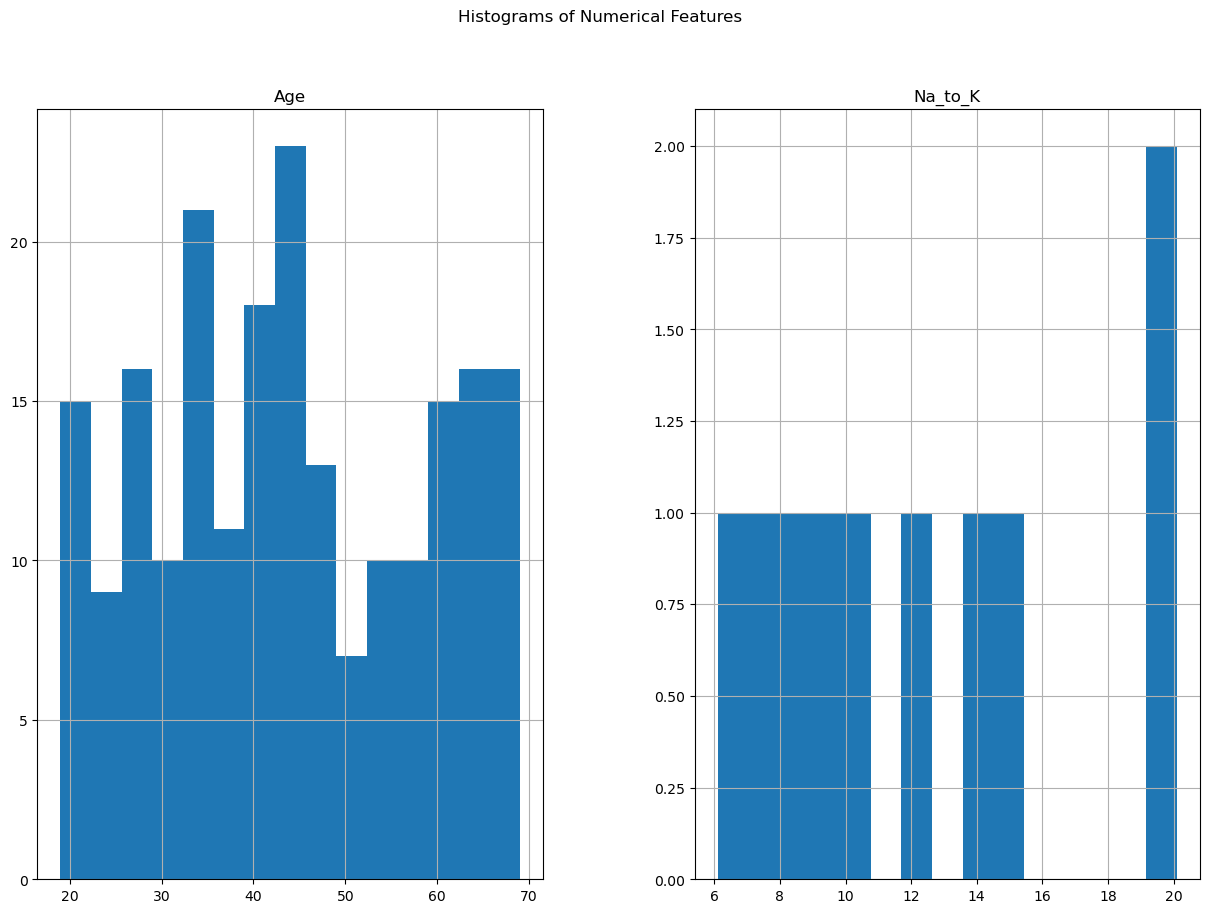

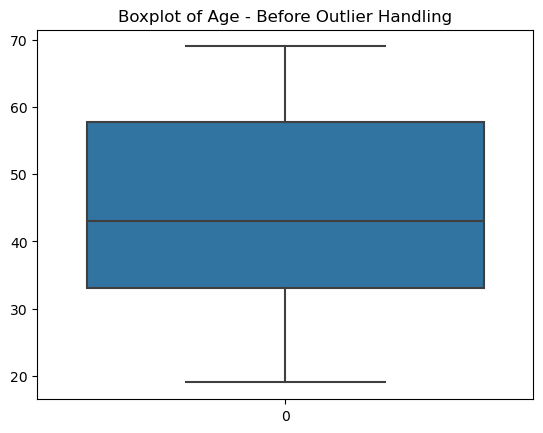

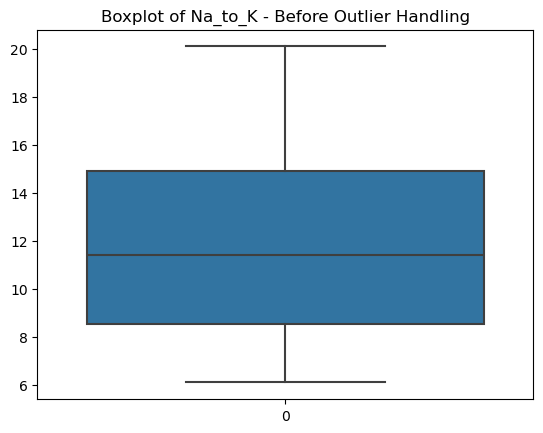

C:\Users\Charmine th\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Charmine th\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


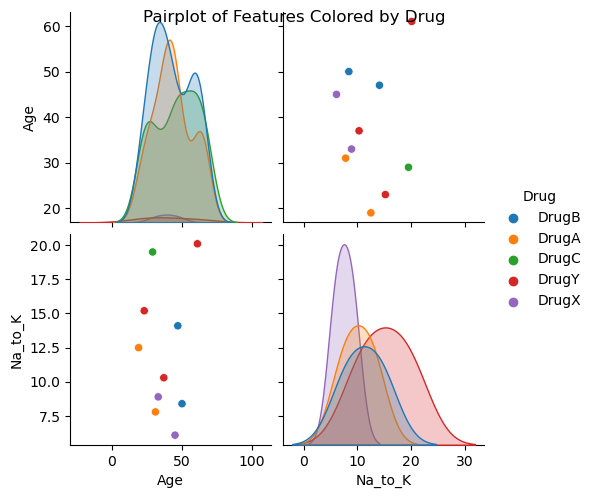

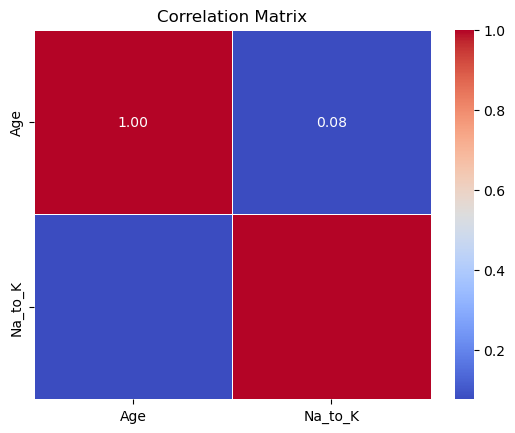

2025-02-01 12:34:54,694 - INFO - Missing data found, filling with mean values.


Fitting 3 folds for each of 216 candidates, totalling 648 fits


In [ ]:

import pandas as pd

import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, precision_recall_curve

from sklearn.model_selection import learning_curve

from imblearn.over_sampling import SMOTE

import joblib

import numpy as np

from sklearn.preprocessing import label_binarize

import logging

 

# Configure logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

 

# Step 1: Load Datasets

def load_datasets(file_paths):

    dataframes = []

    for file_path in file_paths:

        try:

            df = pd.read_csv(file_path)

            logging.info(f"Dataset from '{file_path}' loaded successfully!")

            logging.info("Dataset Preview:\n")

            logging.info(df.head())

            dataframes.append(df)

        except FileNotFoundError:

            logging.error(f"File '{file_path}' not found.")

            exit()

    return dataframes

 

# Step 2: Combine Datasets

def combine_datasets(datasets):

    combined_df = pd.concat(datasets, ignore_index=True)

    logging.info("\nCombined Dataset Preview:")

    logging.info(combined_df.head())

    return combined_df

 

# Step 3: Data Validation

def validate_dataset(df, required_columns):

    logging.info("Validating dataset...")

    missing_columns = [col for col in required_columns if col not in df.columns]

    if missing_columns:

        logging.error(f"Missing required columns: {missing_columns}")

        raise ValueError(f"Dataset is missing required columns: {missing_columns}")

    if df.isnull().any().any():

        logging.warning("Dataset contains missing values.")

    logging.info("Dataset validation passed successfully.")

    return df

 

# Step 4: Outlier Detection and Handling

def handle_outliers(df, numerical_cols):

    logging.info("Handling outliers in numerical columns...")

    for col in numerical_cols:

        Q1 = df[col].quantile(0.25)

        Q3 = df[col].quantile(0.75)

        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR

        upper_bound = Q3 + 1.5 * IQR

        outliers = ((df[col] < lower_bound) | (df[col] > upper_bound))

        if outliers.any():

            logging.warning(f"Outliers detected in column '{col}'. Replacing with median.")

            df.loc[outliers, col] = df[col].median()

    logging.info("Outliers handled successfully.")

    return df

 

# Step 5: Visualize Dataset Statistics

def visualize_data(df):

    # 1. Countplot for target variable distribution

    sns.countplot(data=df, x='Drug', palette='Set2')

    plt.title('Drug Distribution')

    plt.show()

 

    # 2. Histograms for numerical features

    numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns

    df[numerical_cols].hist(bins=15, figsize=(15, 10))

    plt.suptitle('Histograms of Numerical Features')

    plt.show()

 

    # 3. Boxplots for Outlier Detection (Before Handling)

    for col in numerical_cols:

        sns.boxplot(df[col])

        plt.title(f'Boxplot of {col} - Before Outlier Handling')

        plt.show()

 

    # 4. Pairplot for relationships

    sns.pairplot(df, hue='Drug')

    plt.suptitle('Pairplot of Features Colored by Drug')

    plt.show()

 

    # 5. Correlation heatmap

    corr_matrix = df[numerical_cols].corr()

    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

    plt.title('Correlation Matrix')

    plt.show()

 

# Step 6: Preprocessing

def preprocess_data(df):

    required_columns = ['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K', 'Drug']

    numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns

 

    # Validate Dataset

    df = validate_dataset(df, required_columns)

 

    # Handle Outliers

    df = handle_outliers(df, numerical_cols)

 

    # Visualize data

    visualize_data(df)

 

    # Encode Categorical Features

    label_encoders = {}

    for col in ['Sex', 'BP', 'Cholesterol', 'Drug']:

        le = LabelEncoder()

        df[col] = le.fit_transform(df[col])

        label_encoders[col] = le

 

    # Split features and target

    X = df.drop('Drug', axis=1)

    y = df['Drug']

 

    # Handle missing data if necessary

    if X.isnull().sum().any():

        logging.info("Missing data found, filling with mean values.")

        X.fillna(X.mean(), inplace=True)

 

    # Standardize features

    scaler = StandardScaler()

    X_scaled = scaler.fit_transform(X)

 

    return X_scaled, y, label_encoders, scaler, X.columns

 

# Step 7: Train-Test Split

def split_data(X, y):

    return train_test_split(X, y, test_size=0.2, random_state=42)

 

# Step 8: Handle Class Imbalance

def handle_imbalance(X_train, y_train):

    # Get the counts of each class to determine the minimum number of samples in the minority class

    class_counts = y_train.value_counts()

    min_samples = class_counts.min()  # Get the minimum sample count in the minority class

 

    # Adjust k_neighbors based on the minimum sample size

    k_neighbors = min(min_samples - 1, 5)  # k_neighbors should be less than or equal to min_samples - 1

 

    smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=k_neighbors)

    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

   

    return X_resampled, y_resampled

 

# Step 9: Model Training and Optimization (GridSearch)

def train_model(X_train, y_train):

    model = RandomForestClassifier(random_state=42)

 

    # Hyperparameter tuning using GridSearchCV

    param_grid = {

        'n_estimators': [50, 100, 200],

        'max_depth': [None, 10, 20, 30],

        'min_samples_split': [2, 5, 10],

        'min_samples_leaf': [1, 2, 4],

        'bootstrap': [True, False]

    }

 

    grid_search = GridSearchCV(estimator=model, param_grid=param_grid,

                               cv=3, scoring='accuracy', verbose=2, n_jobs=-1)

    grid_search.fit(X_train, y_train)

 

    logging.info("Best Parameters found via GridSearchCV: %s", grid_search.best_params_)

    return grid_search.best_estimator_

 

# Step 10: Evaluation

def evaluate_model(model, X_test, y_test, label_encoders, feature_names):

    y_pred = model.predict(X_test)

    logging.info("\nClassification Report:")

    logging.info(classification_report(y_test, y_pred))

 

    cm = confusion_matrix(y_test, y_pred)

    # Normalized Confusion Matrix

    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',

                xticklabels=label_encoders['Drug'].classes_,

                yticklabels=label_encoders['Drug'].classes_)

    plt.xlabel('Predicted')

    plt.ylabel('True')

    plt.title('Normalized Confusion Matrix')

    plt.show()

 

    accuracy = accuracy_score(y_test, y_pred)

    logging.info(f"\nAccuracy Score: {accuracy * 100:.2f}%")

 

    # Feature importance

    feature_importances = model.feature_importances_

    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)

    sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')

    plt.title('Feature Importance')

    plt.show()

 

    # Learning Curve

    train_sizes, train_scores, test_scores = learning_curve(model, X_test, y_test, cv=3, n_jobs=-1)

    plt.plot(train_sizes, train_scores.mean(axis=1), label='Training Score')

    plt.plot(train_sizes, test_scores.mean(axis=1), label='Cross-validation Score')

    plt.title('Learning Curve')

    plt.xlabel('Training Size')

    plt.ylabel('Score')

    plt.legend(loc='best')

    plt.show()

 

    # ROC Curve for Multiclass

    y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

    y_pred_prob = model.predict_proba(X_test)

    plt.figure(figsize=(8, 6))

    for i in range(y_test_bin.shape[1]):

        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])

        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, lw=2, label=f'ROC curve (class {label_encoders["Drug"].classes_[i]}), AUC = {roc_auc:.2f}')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    plt.xlabel('False Positive Rate')

    plt.ylabel('True Positive Rate')

    plt.title('Receiver Operating Characteristic (ROC) Curve')

    plt.legend(loc='lower right')

    plt.show()

 

# Step 11: Save Model

def save_model(model, scaler, label_encoders, file_path="drug_model.joblib"):

    joblib.dump({'model': model, 'scaler': scaler, 'label_encoders': label_encoders}, file_path)

    logging.info(f"Model saved to {file_path}")

 

# Main Function

def main():

    file_paths = ["drug_dataset1.csv", "drug_dataset2.csv", "drug_dataset3.csv"]

   

    # Load datasets

    datasets = load_datasets(file_paths)

   

    # Combine datasets into one

    combined_df = combine_datasets(datasets)

   

    # Preprocess data

    X, y, label_encoders, scaler, feature_names = preprocess_data(combined_df)

   

    # Train-Test Split

    X_train, X_test, y_train, y_test = split_data(X, y)

   

    # Handle class imbalance

    X_train_resampled, y_train_resampled = handle_imbalance(X_train, y_train)

   

    # Train model

    model = train_model(X_train_resampled, y_train_resampled)

   

    # Evaluate model

    evaluate_model(model, X_test, y_test, label_encoders, feature_names)

   

    # Save the model

    save_model(model, scaler, label_encoders)

   

# Run the main function

if __name__ == "__main__":

    main()